In [ ]:
# CNN

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models, Input
from keras import backend as K
from keras import regularizers
from keras.utils import Sequence
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float16'

Using TensorFlow backend.


In [2]:
# INIT
# PART 1
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 10001, 1000))
number_samples = [30, 60, 90, 120, 150, 180, 210] 
# number_samples = [4096, 4915, 5734, 6554, 7373, 8192]

# cnn_type = "classification"  # {"classification", "regression"}
validation_size, noise_floor = 0.2, -90.0#-110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 100, 100, 5, 10  # su_size:30 for 1000, 10 for 100
cell_size = int(max(max_x, max_y)/10)
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 4, 1
propagation_model = 'testbed' # 'splat', 'log', 'testbed'
noise, std = False, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 18
    sensors_file_path = "rsc/sensors/" + str(max(max_x, max_y)) + "/" + str(sensors_num) + "/sensors"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 5
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else "/pus") + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [3]:
image_dir

'ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/images'

In [7]:
dataframe_sensor.values[9]

array([-48.2, -48.38, ' -48.37', ' -48.44', -48.41, -47.95, -48.37, -48.4,
       -48.08, -48.23, ' -48.28', -47.93, -48.47, -48.03, -48.31, ' nan',
       ' -48.14', -48.32, 2.0, 8.0, 26], dtype=object)

In [26]:
print(data_reg[46])
print(data_reg_sensor[46])

[ 1.  8.  6. 66.  9.  6. 34. nan nan nan nan nan nan nan nan 34.]
[-48.18 -48.29 -48.33 -48.18 -48.23 -48.33 -47.68 -48.31 -48.28 -48.34
 -48.39 -48.42 -48.41 -48.37 -48.36 -48.32 -48.37 -48.37 9.0 6.0 34]


In [21]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3
cols = [i for i in range(num_columns)]
dataset_name = "testbed_pu_1"
# max_dataset_name = "dynamic_pus_max_power_60000_min10_max20PUs_1SUs_square100grid_splat_2020_06_28_13_45.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
#     set_file.write(max_dataset_name)

dataframe = pd.read_csv('ML/data/'
                        + dataset_name, delimiter=',', header=None, names=cols)
# dataframe_max = pd.read_csv('../../../java_workspace/research/spectrum_allocation/resources/data/'
#                             + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
# dataframe_max.reset_index(drop=True, inplace=True)
# dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

# dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
#                         ignore_index=True)

# idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
# dataframe_tot.drop(idx, inplace=True)
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
data_reg = dataframe.values
data_reg[data_reg < noise_floor] = noise_floor
# data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
#                            dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
# data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
# y_class_power = dataframe_tot.values[:, -1]

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
if not sensors:
    for sample_idx in range(data_reg.shape[0]):
        data_reg[sample_idx][-1] = data_reg[sample_idx][int(data_reg[sample_idx][0]) * 3 + 3]
        
del dataframe

/home/shahrokh/anaconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [23]:
data_reg.shape

(299, 16)

In [ ]:
data_reg = np.concatenate((data_reg[:,:2500], np.ones((4000, 1)), data_reg[:, 2500:2504],
               data_reg[:, 2505:]), axis=1)

In [ ]:
data_reg[0, sensors_num:]

In [ ]:
data_reg = data_reg[:][:30000]

In [ ]:
data_reg[512:1024, :] = data_reg[:512, :]

In [ ]:
data_reg[4096:8192, sensors_num:] = data_reg[:4096, sensors_num:]

In [ ]:
print(data_reg[10, :])
print(data_reg[266, :])

In [6]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log", max_pu_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
            pus_cluster = [(7, 7), (7, 2), (2, 2), (2, 7)]
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1]))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2])))
                pus_dist_cluster = [math.sqrt((pu_x - x)**2 + (pu_y - y)**2) for x,y in pus_cluster]
                pu_p = data[pu_i * 3 + 3]
                pu_channel_idx = pus_dist_cluster.index(min(pus_dist_cluster))
                pu_x *= cell_size
                pu_y *= cell_size
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][pu_channel_idx][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][pu_channel_idx][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][pu_channel_idx][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
                    sensors_location[ss_i].y))), max(noise_floor, data[ss_i])
                ss_channel = 0 
                if -62.5 <= ss_p < -50.0:
                    ss_channel = 1
                elif -75.0 <= ss_p < -62.6:
                    ss_channel = 2
                elif -87.5 <= ss_p < -75.0:
                    ss_channel = 3
                elif -100.0 <= ss_p < -87.5:
                    ss_channel = 4
#                 elif -70.0 <= ss_p < -65.0:
#                     ss_channel = 5
                elif ss_p < -100.0:
                    ss_channel = 5
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1) - 1
        su_num = 1
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1]))) * cell_size
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2]))) * cell_size
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            image[0][0][point.p.x][point.p.y] = 1
                        else:
                            image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
                        
        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
#         su_image = np.zeros((max_x, max_y), dtype=float_memory_used)
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) +su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) + su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if number_image_channels > 1:
                        image[0][1][point.p.x][point.p.y] = su_intensity
                    elif number_image_channels == 1:
                        image[0][0][point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
#         return np.append(pu_image, su_image, axis=0)
        return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-r, -max_x), min(r, max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num):
    if style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

In [ ]:
plt.hist(data_reg[:,0:1:sensors_num], bins='auto')

In [7]:
max_v = -float('inf')
min_v = float('inf')
for sample_idx in range(data_reg.shape[0]):
    pu_n = int(data_reg[sample_idx][0])
    max_v = max(max_v, max(data_reg[sample_idx][3:pu_n*3+1:3]))
    min_v = min(min_v, min(data_reg[sample_idx][3:pu_n*3+1:3]))
    

In [8]:
if not sensors:
    noise_floor = 0

In [9]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=max_v)
        if style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=image)
        del image
        

In [25]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|██████████| 59/59 [00:01<00:00, 39.12it/s]


In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point)

In [ ]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point,"close") if math.sqrt((point.x-917)**2+(point.y-415)**2)<=1.5 else None

In [ ]:
count = [0, 0, 0, 0]
idxx = [[],[],[],[]]
for i in range(data_reg.shape[0]):
    pus_c = int(data_reg[i][0]) * 3 + 1
    idx = int(data_reg[i][pus_c]) - 1
    count[idx] += 1
    idxx[idx].append(i)

In [ ]:
print(count)
print(idxx[3])

In [26]:
imm = read_image(150)

In [ ]:
imm[300].shape

In [ ]:
data_reg[:,-1].shape

In [27]:
data_reg[150]

array([ 3.,  5.,  2., 36.,  0.,  0., 50.,  3.,  5., 48.,  6.,  0., 44.,
       nan, nan, 44.])

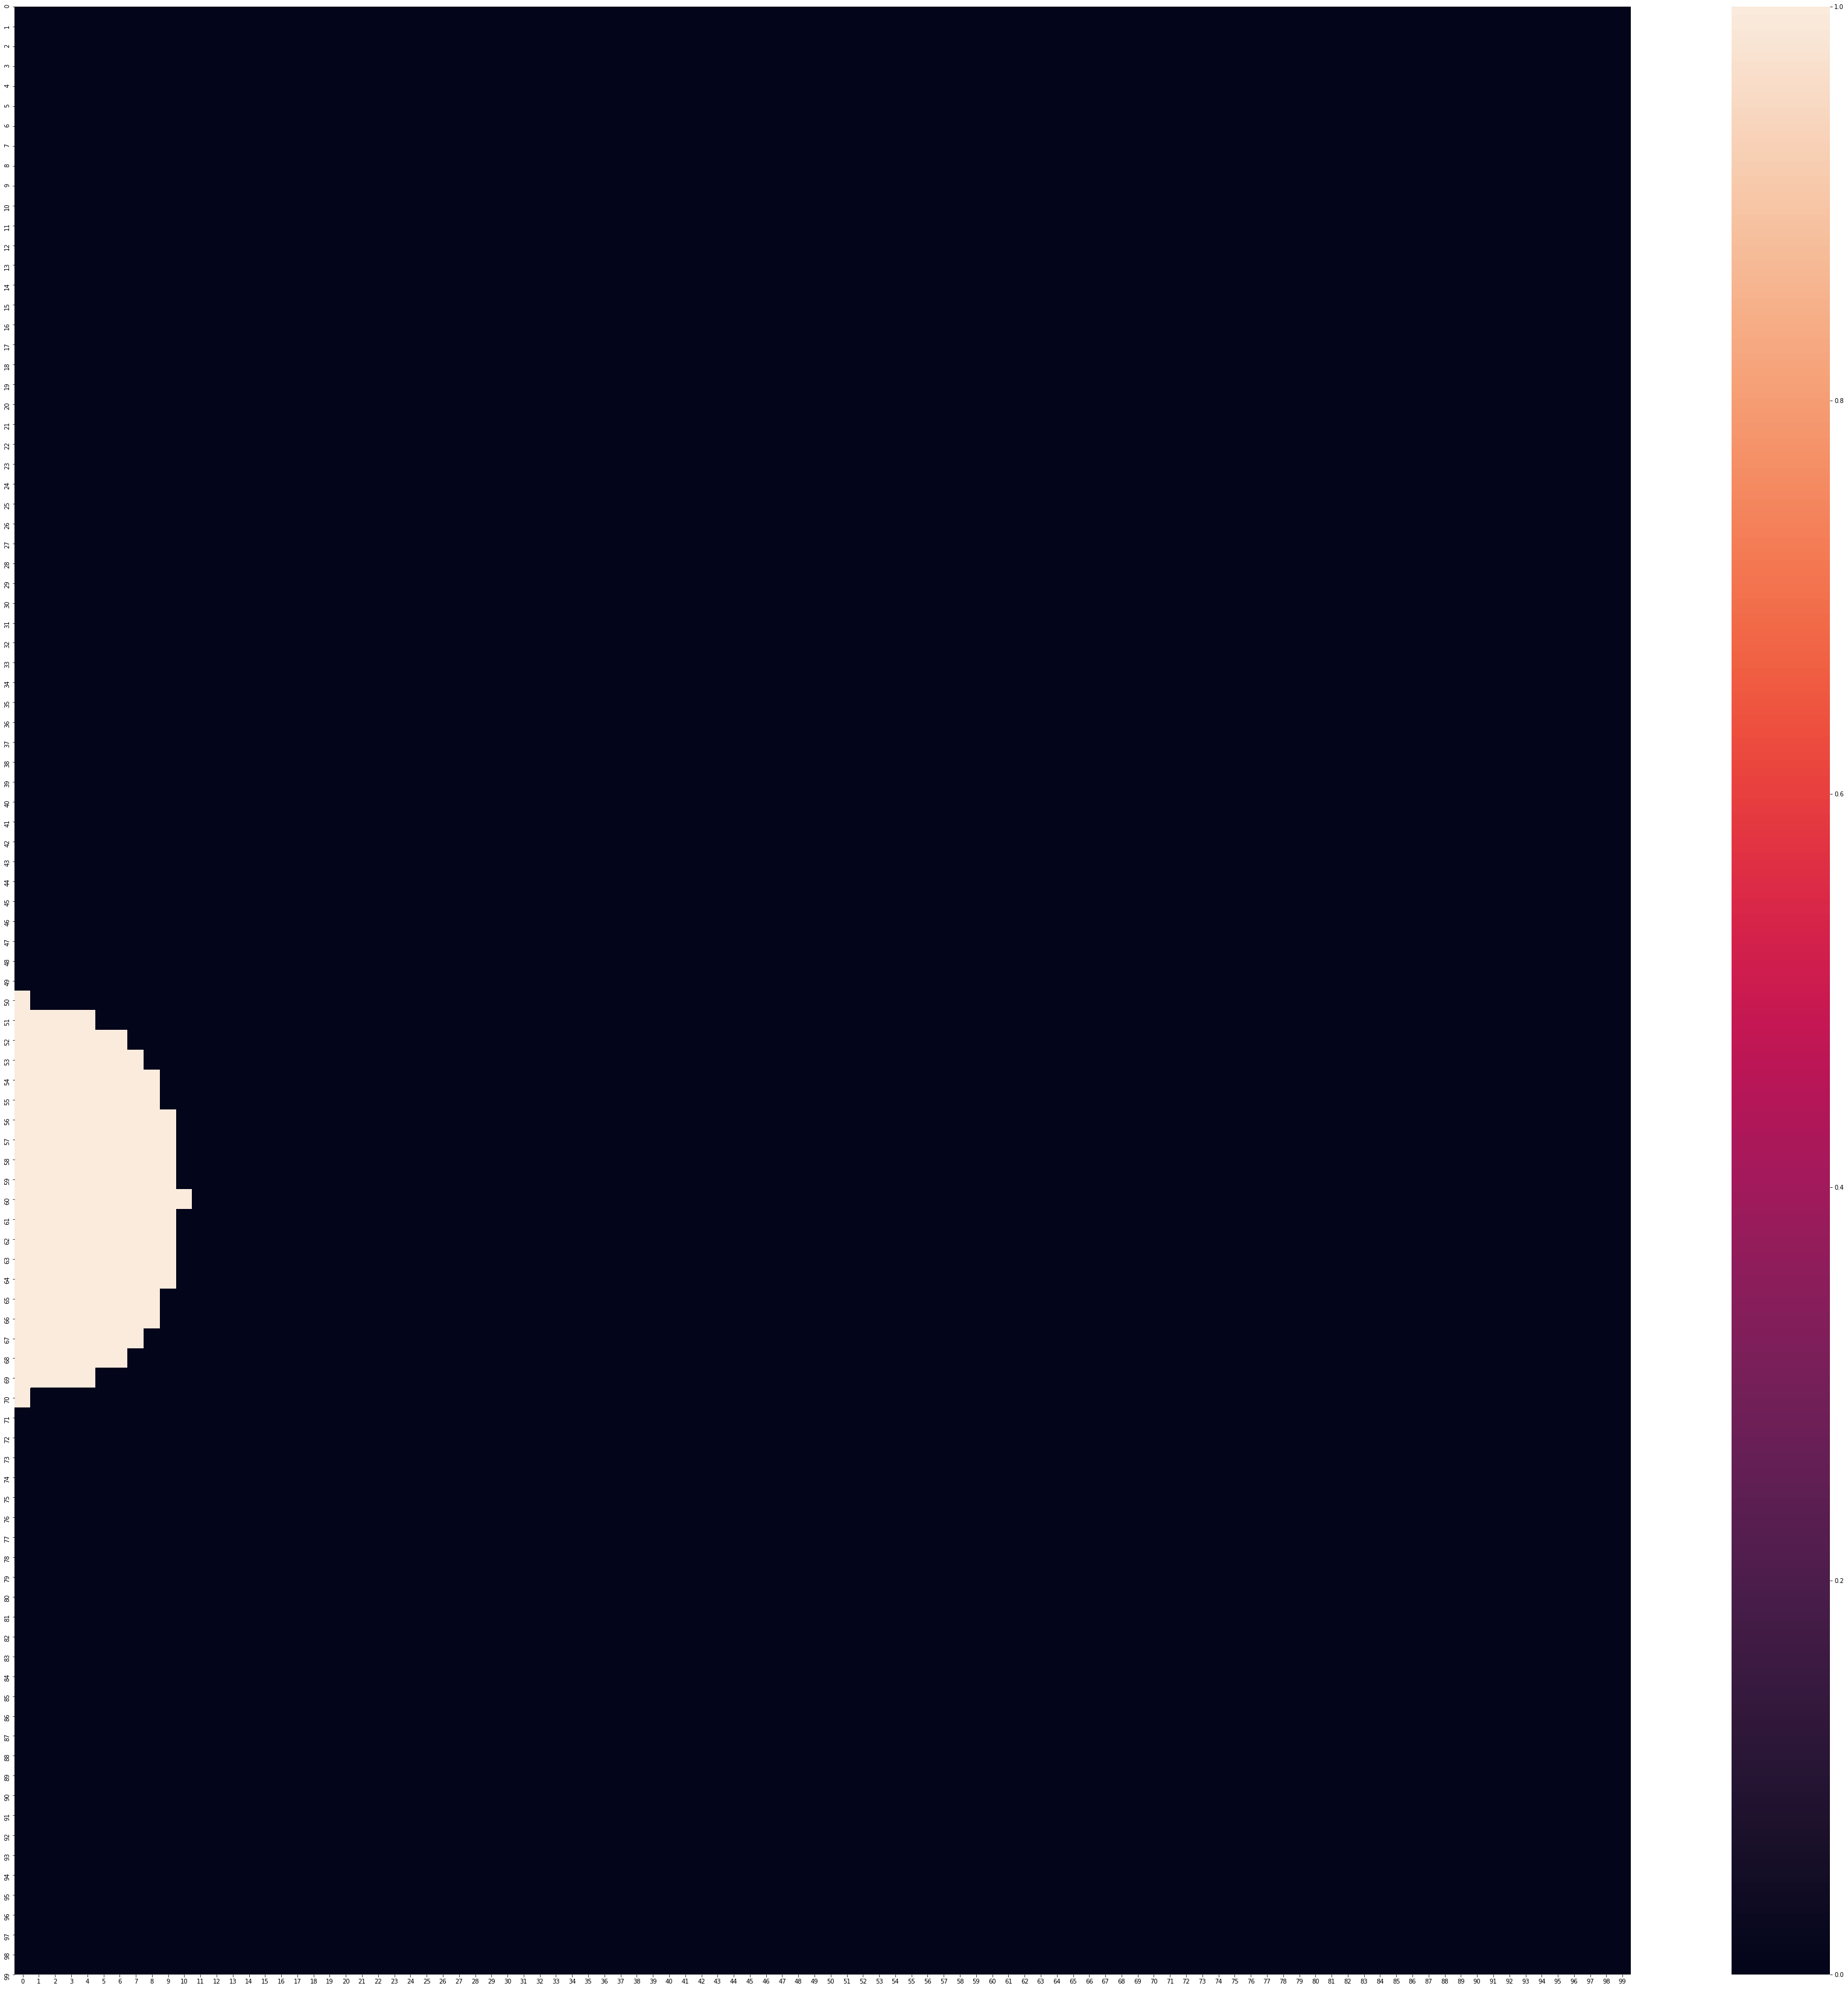

In [31]:
fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(imm[0][4], ax=ax)

In [32]:
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(2*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
# from here for 1000
    if max(max_x, max_y) == 1000:
        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))

        cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                             kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                             kernel_initializer=convolution_init))
    #     cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
    #                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
    #                          kernel_initializer='lecun_normal'))
        cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
        cnn.add(BatchNormalization(axis=1))
    #     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization())
    cnn.add(layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init))
    return cnn


class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, conserve=0):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x, self.max_y), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [33]:
cnn = cnn_model(10, 0, 0)

In [34]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 10, 100, 100)      460       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 10, 50, 50)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 10, 50, 50)        40        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 50, 50)        1820      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 20, 25, 25)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 20, 25, 25)        80        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 25, 25)       

In [35]:
tf.test.is_gpu_available()

False

In [ ]:
# CNN: support batching
TEST, CONSERVE = True, True
mini_batch = 16 if max(max_x, max_y) == 1000 else 256
epochs = 35 if max(max_x, max_y) == 1000 else 100
MAX_QUEUE_SIZE, WORKERS = 6, 1
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0.001, 0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
# lambda_vec = [0.01, 0.1, 1]
# lambda_vec = [10]
# MODEL_PATH = 'models/'
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='adam', 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 30 , New samples: 30
Validation size: 6 , starts: 30 , ends: 35

Epoch 00001: val_mae improved from inf to 48.03308, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00002: val_mae did not improve from 48.03308

Epoch 00003: val_mae did not improve from 48.03308

Epoch 00004: val_mae did not improve from 48.03308

Epoch 00005: val_mae did not improve from 48.03308

Epoch 00006: val_mae did not improve from 48.03308

Epoch 00007: val_mae did not improve from 48.03308

Epoch 00008: val_mae did not improve from 48.03308

Epoch 00009: val_mae improved from 48.03308 to 48.03055, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00010: val_mae improved from 48.03055 to 48.02336, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/colo


Epoch 00047: val_mae improved from 47.44682 to 47.42126, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00048: val_mae improved from 47.42126 to 47.39442, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00049: val_mae improved from 47.39442 to 47.36482, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00050: val_mae improved from 47.36482 to 47.33364, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00051: val_mae improved from 47.33364 to 47.29774, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00088: val_mae improved from 45.21733 to 45.12332, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00089: val_mae improved from 45.12332 to 45.04424, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00090: val_mae improved from 45.04424 to 44.98021, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00091: val_mae improved from 44.98021 to 44.92291, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_0.h5

Epoch 00092: val_mae improved from 44.92291 to 44.86456, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00023: val_mae improved from 47.95717 to 47.94006, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00024: val_mae improved from 47.94006 to 47.92150, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00025: val_mae improved from 47.92150 to 47.90198, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00026: val_mae improved from 47.90198 to 47.88113, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00027: val_mae improved from 47.88113 to 47.85836, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00064: val_mae improved from 46.45823 to 46.40451, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00065: val_mae improved from 46.40451 to 46.36099, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00066: val_mae improved from 46.36099 to 46.32394, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00067: val_mae improved from 46.32394 to 46.27532, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_1.h5

Epoch 00068: val_mae improved from 46.27532 to 46.21880, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00001: val_mae improved from inf to 47.99507, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00002: val_mae did not improve from 47.99507

Epoch 00003: val_mae did not improve from 47.99507

Epoch 00004: val_mae did not improve from 47.99507

Epoch 00005: val_mae did not improve from 47.99507

Epoch 00006: val_mae did not improve from 47.99507

Epoch 00007: val_mae did not improve from 47.99507

Epoch 00008: val_mae did not improve from 47.99507

Epoch 00009: val_mae did not improve from 47.99507

Epoch 00010: val_mae did not improve from 47.99507

Epoch 00011: val_mae did not improve from 47.99507

Epoch 00012: val_mae improved from 47.99507 to 47.98764, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00013: val_mae improved from 47.98764 to 47.97825, saving model to ML/data


Epoch 00050: val_mae improved from 46.74057 to 46.67784, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00051: val_mae improved from 46.67784 to 46.61157, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00052: val_mae improved from 46.61157 to 46.54834, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00053: val_mae improved from 46.54834 to 46.48811, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00054: val_mae improved from 46.48811 to 46.42707, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00091: val_mae improved from 42.88385 to 42.75528, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00092: val_mae improved from 42.75528 to 42.60920, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00093: val_mae improved from 42.60920 to 42.47408, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00094: val_mae improved from 42.47408 to 42.32233, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_2.h5

Epoch 00095: val_mae improved from 42.32233 to 42.15784, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00024: val_mae improved from 47.85796 to 47.83489, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00025: val_mae improved from 47.83489 to 47.81257, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00026: val_mae improved from 47.81257 to 47.79197, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00027: val_mae improved from 47.79197 to 47.77188, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00028: val_mae improved from 47.77188 to 47.75080, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la


Epoch 00065: val_mae improved from 46.31597 to 46.25822, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00066: val_mae improved from 46.25822 to 46.19534, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00067: val_mae improved from 46.19534 to 46.11501, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00068: val_mae improved from 46.11501 to 46.02515, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_lambda_3.h5

Epoch 00069: val_mae improved from 46.02515 to 45.94240, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/30/best_model_la

Test starts:  36 , ends:  298
2/2 [==============================] - 1s 334ms/step
average_error:  39.999 , fp_average_error:  0.0



number_samples: 60 , New samples: 60
Validation size: 12 , starts: 60 , ends: 71

Epoch 00001: val_mae improved from inf to 46.28682, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00002: val_mae did not improve from 46.28682

Epoch 00003: val_mae did not improve from 46.28682

Epoch 00004: val_mae did not improve from 46.28682

Epoch 00005: val_mae improved from 46.28682 to 46.28252, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00006: val_mae improved from 46.28252 to 46.27585, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00007: val_mae improv


Epoch 00043: val_mae improved from 45.68008 to 45.65652, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00044: val_mae improved from 45.65652 to 45.63041, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00045: val_mae improved from 45.63041 to 45.60489, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00046: val_mae improved from 45.60489 to 45.57612, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00047: val_mae improved from 45.57612 to 45.54883, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00084: val_mae improved from 44.10556 to 44.04861, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00085: val_mae improved from 44.04861 to 43.98555, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00086: val_mae improved from 43.98555 to 43.92263, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00087: val_mae improved from 43.92263 to 43.85539, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_0.h5

Epoch 00088: val_mae improved from 43.85539 to 43.81482, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00014: val_mae improved from 46.01712 to 45.98710, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00015: val_mae improved from 45.98710 to 45.95669, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00016: val_mae improved from 45.95669 to 45.92597, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00017: val_mae improved from 45.92597 to 45.89547, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00018: val_mae improved from 45.89547 to 45.86449, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00055: val_mae improved from 44.47075 to 44.41019, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00056: val_mae improved from 44.41019 to 44.34877, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00057: val_mae improved from 44.34877 to 44.28619, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00058: val_mae improved from 44.28619 to 44.22268, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00059: val_mae improved from 44.22268 to 44.16056, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00096: val_mae improved from 41.74796 to 41.67865, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00097: val_mae improved from 41.67865 to 41.62597, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00098: val_mae improved from 41.62597 to 41.56853, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00099: val_mae improved from 41.56853 to 41.51544, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_1.h5

Epoch 00100: val_mae improved from 41.51544 to 41.42311, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00025: val_mae improved from 45.72635 to 45.69659, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00026: val_mae improved from 45.69659 to 45.66781, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00027: val_mae improved from 45.66781 to 45.64004, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00028: val_mae improved from 45.64004 to 45.61335, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00029: val_mae improved from 45.61335 to 45.58689, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00066: val_mae improved from 43.95804 to 43.90354, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00067: val_mae improved from 43.90354 to 43.84131, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00068: val_mae improved from 43.84131 to 43.77964, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00069: val_mae improved from 43.77964 to 43.71812, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_2.h5

Epoch 00070: val_mae improved from 43.71812 to 43.66087, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00001: val_mae improved from inf to 46.25190, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00002: val_mae improved from 46.25190 to 46.25064, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00003: val_mae improved from 46.25064 to 46.24504, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00004: val_mae improved from 46.24504 to 46.23862, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00005: val_mae improved from 46.23862 to 46.23043, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_


Epoch 00042: val_mae improved from 45.61332 to 45.58946, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00043: val_mae improved from 45.58946 to 45.56245, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00044: val_mae improved from 45.56245 to 45.53114, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00045: val_mae improved from 45.53114 to 45.50298, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00046: val_mae improved from 45.50298 to 45.48055, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_la


Epoch 00083: val_mae improved from 44.26693 to 44.25412, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00084: val_mae improved from 44.25412 to 44.15137, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00085: val_mae did not improve from 44.15137

Epoch 00086: val_mae improved from 44.15137 to 44.07607, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00087: val_mae improved from 44.07607 to 43.97056, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/60/best_model_lambda_3.h5

Epoch 00088: val_mae did not improve from 43.97056

Epoch 00089: val_mae improved from 43.97056 to 43.94885, saving model to ML/data/pictur


Epoch 00013: val_mae improved from 48.57589 to 48.56250, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00014: val_mae improved from 48.56250 to 48.54829, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00015: val_mae improved from 48.54829 to 48.53269, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00016: val_mae improved from 48.53269 to 48.51643, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00017: val_mae improved from 48.51643 to 48.50001, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00054: val_mae improved from 47.54273 to 47.50091, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00055: val_mae improved from 47.50091 to 47.46825, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00056: val_mae improved from 47.46825 to 47.43246, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00057: val_mae improved from 47.43246 to 47.38932, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00058: val_mae improved from 47.38932 to 47.34529, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00095: val_mae improved from 44.39275 to 44.24224, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00096: val_mae improved from 44.24224 to 44.10061, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00097: val_mae improved from 44.10061 to 43.90789, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00098: val_mae improved from 43.90789 to 43.70450, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_0.h5

Epoch 00099: val_mae improved from 43.70450 to 43.46864, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00041: val_mae improved from 48.41028 to 48.39270, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00042: val_mae improved from 48.39270 to 48.36386, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00043: val_mae improved from 48.36386 to 48.33662, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00044: val_mae improved from 48.33662 to 48.31356, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00045: val_mae improved from 48.31356 to 48.28927, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00083: val_mae improved from 45.85562 to 45.73280, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00084: val_mae improved from 45.73280 to 45.66197, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00085: val_mae did not improve from 45.66197

Epoch 00086: val_mae improved from 45.66197 to 45.63707, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00087: val_mae improved from 45.63707 to 45.60358, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_1.h5

Epoch 00088: val_mae improved from 45.60358 to 45.52837, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_


Epoch 00019: val_mae improved from 48.58270 to 48.57143, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00020: val_mae improved from 48.57143 to 48.55941, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00021: val_mae improved from 48.55941 to 48.54674, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00022: val_mae improved from 48.54674 to 48.53271, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00023: val_mae improved from 48.53271 to 48.51677, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00060: val_mae improved from 47.59861 to 47.57187, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00061: val_mae improved from 47.57187 to 47.54295, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00062: val_mae improved from 47.54295 to 47.48529, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00063: val_mae improved from 47.48529 to 47.43934, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_2.h5

Epoch 00064: val_mae improved from 47.43934 to 47.39248, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00001: val_mae improved from inf to 48.70609, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00002: val_mae did not improve from 48.70609

Epoch 00003: val_mae did not improve from 48.70609

Epoch 00004: val_mae did not improve from 48.70609

Epoch 00005: val_mae improved from 48.70609 to 48.70558, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00006: val_mae improved from 48.70558 to 48.69772, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00007: val_mae improved from 48.69772 to 48.68950, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00008: val_mae improved from 48.68


Epoch 00044: val_mae improved from 48.04896 to 48.01808, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00045: val_mae improved from 48.01808 to 47.98925, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00046: val_mae improved from 47.98925 to 47.96496, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00047: val_mae improved from 47.96496 to 47.94117, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00048: val_mae improved from 47.94117 to 47.90913, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00085: val_mae improved from 46.25151 to 46.18552, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00086: val_mae improved from 46.18552 to 46.10498, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00087: val_mae improved from 46.10498 to 46.05798, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00088: val_mae improved from 46.05798 to 46.01403, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_lambda_3.h5

Epoch 00089: val_mae improved from 46.01403 to 45.96597, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/90/best_model_la


Epoch 00035: val_mae did not improve from 44.34563

Epoch 00036: val_mae did not improve from 44.34563

Epoch 00037: val_mae did not improve from 44.34563

Epoch 00038: val_mae did not improve from 44.34563

Epoch 00039: val_mae did not improve from 44.34563

Epoch 00040: val_mae improved from 44.34563 to 44.34542, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00041: val_mae improved from 44.34542 to 44.33828, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00042: val_mae improved from 44.33828 to 44.32483, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00043: val_mae improved from 44.32483 to 44.31905, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/r


Epoch 00089: val_mae improved from 42.63594 to 42.63269, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00090: val_mae improved from 42.63269 to 42.50632, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00091: val_mae did not improve from 42.50632

Epoch 00092: val_mae improved from 42.50632 to 42.41885, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00093: val_mae improved from 42.41885 to 42.35178, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_0.h5

Epoch 00094: val_mae improved from 42.35178 to 42.30304, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00036: val_mae improved from 44.24368 to 44.23320, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00037: val_mae improved from 44.23320 to 44.22413, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00038: val_mae improved from 44.22413 to 44.21297, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00039: val_mae improved from 44.21297 to 44.19785, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00040: val_mae improved from 44.19785 to 44.17887, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_mod


Epoch 00078: val_mae improved from 42.85079 to 42.78389, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00079: val_mae improved from 42.78389 to 42.73237, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00080: val_mae improved from 42.73237 to 42.69252, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00081: val_mae improved from 42.69252 to 42.59681, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_1.h5

Epoch 00082: val_mae improved from 42.59681 to 42.55846, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_mod


Epoch 00012: val_mae improved from 44.25106 to 44.24416, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00013: val_mae improved from 44.24416 to 44.23516, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00014: val_mae improved from 44.23516 to 44.22688, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00015: val_mae improved from 44.22688 to 44.22124, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00016: val_mae improved from 44.22124 to 44.21861, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_mod


Epoch 00055: val_mae improved from 43.26796 to 43.24097, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00056: val_mae improved from 43.24097 to 43.18391, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00057: val_mae improved from 43.18391 to 43.16809, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00058: val_mae improved from 43.16809 to 43.13317, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_2.h5

Epoch 00059: val_mae improved from 43.13317 to 43.09226, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_mod


Epoch 00001: val_mae improved from inf to 44.34179, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00002: val_mae did not improve from 44.34179

Epoch 00003: val_mae did not improve from 44.34179

Epoch 00004: val_mae did not improve from 44.34179

Epoch 00005: val_mae did not improve from 44.34179

Epoch 00006: val_mae did not improve from 44.34179

Epoch 00007: val_mae did not improve from 44.34179

Epoch 00008: val_mae did not improve from 44.34179

Epoch 00009: val_mae improved from 44.34179 to 44.33949, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00010: val_mae improved from 44.33949 to 44.33149, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00011: val_mae improved f


Epoch 00047: val_mae improved from 43.58879 to 43.56083, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00048: val_mae improved from 43.56083 to 43.53531, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00049: val_mae improved from 43.53531 to 43.49974, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00050: val_mae improved from 43.49974 to 43.46686, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00051: val_mae improved from 43.46686 to 43.44438, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_mod


Epoch 00088: val_mae improved from 41.46128 to 41.39981, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00089: val_mae improved from 41.39981 to 41.33532, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00090: val_mae improved from 41.33532 to 41.23357, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00091: val_mae improved from 41.23357 to 41.18879, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_model_lambda_3.h5

Epoch 00092: val_mae improved from 41.18879 to 41.13854, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/120/best_mod


Epoch 00021: val_mae improved from 48.84942 to 48.82231, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_0.h5

Epoch 00022: val_mae improved from 48.82231 to 48.79167, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_0.h5

Epoch 00023: val_mae improved from 48.79167 to 48.75811, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_0.h5

Epoch 00024: val_mae improved from 48.75811 to 48.72309, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_0.h5

Epoch 00025: val_mae improved from 48.72309 to 48.68811, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00063: val_mae did not improve from 47.27886

Epoch 00064: val_mae did not improve from 47.27886

Epoch 00065: val_mae did not improve from 47.27886

Epoch 00066: val_mae did not improve from 47.27886

Epoch 00067: val_mae did not improve from 47.27886

Epoch 00068: val_mae did not improve from 47.27886

Epoch 00069: val_mae did not improve from 47.27886

Epoch 00070: val_mae did not improve from 47.27886

Epoch 00071: val_mae did not improve from 47.27886

Epoch 00072: val_mae did not improve from 47.27886

Epoch 00073: val_mae did not improve from 47.27886

Epoch 00074: val_mae did not improve from 47.27886

Epoch 00075: val_mae did not improve from 47.27886

Epoch 00076: val_mae did not improve from 47.27886

Epoch 00077: val_mae did not improve from 47.27886

Epoch 00078: val_mae did not improve from 47.27886

Epoch 00079: val_mae did not improve from 47.27886

Epoch 00080: val_mae did not improve from 47.27886

Epoch 00081: val_mae did not improve from 47.27886

Epoch 00082


Epoch 00022: val_mae improved from 48.90728 to 48.89539, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00023: val_mae improved from 48.89539 to 48.88325, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00024: val_mae improved from 48.88325 to 48.87135, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00025: val_mae improved from 48.87135 to 48.85795, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00026: val_mae improved from 48.85795 to 48.84350, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00067: val_mae improved from 46.95150 to 46.85069, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00068: val_mae improved from 46.85069 to 46.61944, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00069: val_mae improved from 46.61944 to 46.55245, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00070: val_mae improved from 46.55245 to 46.46552, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_1.h5

Epoch 00071: val_mae improved from 46.46552 to 46.30861, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00001: val_mae improved from inf to 48.96317, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00002: val_mae did not improve from 48.96317

Epoch 00003: val_mae did not improve from 48.96317

Epoch 00004: val_mae did not improve from 48.96317

Epoch 00005: val_mae did not improve from 48.96317

Epoch 00006: val_mae did not improve from 48.96317

Epoch 00007: val_mae improved from 48.96317 to 48.96239, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00008: val_mae improved from 48.96239 to 48.95522, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00009: val_mae improved from 48.95522 to 48.94535, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_po


Epoch 00046: val_mae improved from 47.83397 to 47.79332, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00047: val_mae improved from 47.79332 to 47.75552, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00048: val_mae improved from 47.75552 to 47.72022, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00049: val_mae improved from 47.72022 to 47.67981, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00050: val_mae improved from 47.67981 to 47.65544, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00088: val_mae improved from 45.87944 to 45.79966, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00089: val_mae improved from 45.79966 to 45.78804, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00090: val_mae improved from 45.78804 to 45.65168, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00091: val_mae improved from 45.65168 to 45.57811, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_2.h5

Epoch 00092: val_mae improved from 45.57811 to 45.54009, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00018: val_mae improved from 48.80733 to 48.78824, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00019: val_mae improved from 48.78824 to 48.77029, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00020: val_mae improved from 48.77029 to 48.75292, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00021: val_mae improved from 48.75292 to 48.73534, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00022: val_mae improved from 48.73534 to 48.71687, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00059: val_mae improved from 47.71009 to 47.68520, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00060: val_mae improved from 47.68520 to 47.64613, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00061: val_mae improved from 47.64613 to 47.60231, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00062: val_mae improved from 47.60231 to 47.57162, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Epoch 00063: val_mae improved from 47.57162 to 47.53180, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_mod


Epoch 00100: val_mae improved from 45.59562 to 45.46565, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/150/best_model_lambda_3.h5

Lambda: 1 , Time: 0:02:03
Train Error(all epochs): 42.881054 
 [45.708, 45.672, 45.653, 45.639, 45.624, 45.611, 45.598, 45.587, 45.576, 45.566, 45.556, 45.547, 45.537, 45.528, 45.519, 45.509, 45.5, 45.49, 45.481, 45.471, 45.46, 45.449, 45.437, 45.426, 45.413, 45.401, 45.388, 45.374, 45.36, 45.346, 45.331, 45.315, 45.3, 45.285, 45.269, 45.252, 45.235, 45.218, 45.2, 45.182, 45.163, 45.145, 45.126, 45.105, 45.084, 45.063, 45.041, 45.019, 44.999, 44.974, 44.956, 44.928, 44.898, 44.878, 44.847, 44.819, 44.796, 44.766, 44.735, 44.707, 44.681, 44.649, 44.619, 44.589, 44.556, 44.522, 44.486, 44.449, 44.419, 44.383, 44.347, 44.312, 44.262, 44.228, 44.184, 44.136, 44.099, 44.059, 44.015, 43.972, 43.927, 43.885, 43.823, 43.779, 43.743, 43.681, 43.624, 43.586, 43.528, 43.467, 43.418, 43.353, 43.30


Epoch 00031: val_mae improved from 46.42361 to 46.39733, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00032: val_mae improved from 46.39733 to 46.37085, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00033: val_mae improved from 46.37085 to 46.34408, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00034: val_mae improved from 46.34408 to 46.31711, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00035: val_mae improved from 46.31711 to 46.28624, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00077: val_mae improved from 44.92920 to 44.85581, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00078: val_mae improved from 44.85581 to 44.85102, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00079: val_mae improved from 44.85102 to 44.77538, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00080: val_mae improved from 44.77538 to 44.71380, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_0.h5

Epoch 00081: val_mae improved from 44.71380 to 44.68435, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00007: val_mae improved from 46.78694 to 46.77468, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00008: val_mae improved from 46.77468 to 46.75954, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00009: val_mae improved from 46.75954 to 46.74054, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00010: val_mae improved from 46.74054 to 46.71886, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00011: val_mae improved from 46.71886 to 46.69696, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00048: val_mae improved from 45.49037 to 45.42046, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00049: val_mae improved from 45.42046 to 45.34763, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00050: val_mae improved from 45.34763 to 45.27643, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00051: val_mae improved from 45.27643 to 45.20014, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00052: val_mae improved from 45.20014 to 45.13363, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00090: val_mae improved from 41.75831 to 41.58046, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00091: val_mae improved from 41.58046 to 41.54439, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00092: val_mae improved from 41.54439 to 41.51497, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00093: val_mae improved from 41.51497 to 41.38233, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_1.h5

Epoch 00094: val_mae improved from 41.38233 to 41.25307, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00019: val_mae improved from 46.66945 to 46.66288, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00020: val_mae improved from 46.66288 to 46.65646, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00021: val_mae improved from 46.65646 to 46.65084, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00022: val_mae improved from 46.65084 to 46.64566, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00023: val_mae improved from 46.64566 to 46.64022, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00060: val_mae improved from 45.97091 to 45.92873, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00061: val_mae improved from 45.92873 to 45.87095, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00062: val_mae improved from 45.87095 to 45.84248, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00063: val_mae improved from 45.84248 to 45.79733, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_2.h5

Epoch 00064: val_mae improved from 45.79733 to 45.73977, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00001: val_mae improved from inf to 46.80656, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00002: val_mae did not improve from 46.80656

Epoch 00003: val_mae did not improve from 46.80656

Epoch 00004: val_mae did not improve from 46.80656

Epoch 00005: val_mae improved from 46.80656 to 46.80143, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00006: val_mae improved from 46.80143 to 46.78320, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00007: val_mae improved from 46.78320 to 46.76128, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00008: val_mae improved from 4


Epoch 00044: val_mae improved from 45.52512 to 45.47740, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00045: val_mae improved from 45.47740 to 45.43059, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00046: val_mae improved from 45.43059 to 45.38517, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00047: val_mae improved from 45.38517 to 45.34073, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00048: val_mae improved from 45.34073 to 45.29558, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00085: val_mae improved from 44.09850 to 44.04106, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00086: val_mae improved from 44.04106 to 44.00822, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00087: val_mae improved from 44.00822 to 44.00423, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00088: val_mae improved from 44.00423 to 43.93453, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_model_lambda_3.h5

Epoch 00089: val_mae improved from 43.93453 to 43.86415, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/180/best_mod


Epoch 00018: val_mae improved from 48.51934 to 48.49441, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00019: val_mae improved from 48.49441 to 48.46877, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00020: val_mae improved from 48.46877 to 48.44322, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00021: val_mae improved from 48.44322 to 48.41800, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00022: val_mae improved from 48.41800 to 48.39264, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_mod


Epoch 00059: val_mae did not improve from 47.32266

Epoch 00060: val_mae improved from 47.32266 to 47.29595, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00061: val_mae did not improve from 47.29595

Epoch 00062: val_mae improved from 47.29595 to 47.24688, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00063: val_mae improved from 47.24688 to 47.21815, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00064: val_mae did not improve from 47.21815

Epoch 00065: val_mae improved from 47.21815 to 47.13813, saving model to ML/data/pictures_100_100/testbed/pu_circle_su_circle_10/raw_power_min_max_norm/color/log_5/pus/models/210/best_model_lambda_0.h5

Epoch 00066: val_mae improved f

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
# print(best_lambda)
print(average_diff_power_conserve)
print(fp_mean_power_conserve)
print(best_lambda)

In [ ]:
all_cnns[0][0].history.history

In [ ]:
best_model = all_cnns[0][4]

In [ ]:
if True:
    checkpointers = ModelCheckpoint(filepath=MODEL_PATH + str(0)+ 'new.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    best_model.fit(train_generator, epochs=80, verbose=0,
                   validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False, initial_epoch=60)
    print("Train Error(all epochs):", min(best_model.history.history['mae']), '\n',
          [round(val, 3) for val in best_model.history.history['mae']])
    print("Train FP Error(all epochs):", min(best_model.history.history['fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['fp_mae']])
    print("Val Error(all epochs):", min(best_model.history.history['val_mae']), '\n', 
          [round(val,3) for val in best_model.history.history['val_mae']])
    print("Val FP Error(all epochs):", min(best_model.history.history['val_fp_mae']), '\n',
          [round(val,3) for val in best_model.history.history['val_fp_mae']])
    

In [ ]:
best_best_model = models.load_model(MODEL_PATH + str(0) + 'new.h5', 
                               custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_best_model.evaluate(test_generator, verbose=1, 
                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                    use_multiprocessing=False)

In [ ]:
test_res

In [ ]:
best_model.history.history

In [ ]:
best_model.fit(train_generator, epochs=15, verbose=0,
               validation_data=val_generator, shuffle=True, callbacks=[checkpointers], 
               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
               use_multiprocessing=False, initial_epoch=20)

In [ ]:
models_min_mae = [8.27781, 8.23545, 8.20838]

In [ ]:
average_diff_power = [8.166, 7.844, 7.592]
fp_mean_power = [4.56, 4.42, 4.37]

In [ ]:
# CNN: support batching
TEST = True
mini_batch, epochs = 16, 30
batch_size = (batch_size // mini_batch) * mini_batch
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]  #, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    number_start = time.time()
    current_sample = number_sample - prev_sample
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    val_size = math.ceil(number_sample * validation_size)
#     val_samples = [batch_size] * (val_size//batch_size) + ([val_size%batch_size] if 
#                                                                val_size%batch_size else [])
    
    print('number_samples:', number_sample)
    print("Train batches:", train_samples)
    for i, train_sample in enumerate(train_samples):
        print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
                      ", ends:", prev_sample + i * batch_size + train_sample - 1)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     print("Validation Batches:", val_samples)
#     for i, val_sample in enumerate(val_samples):
#         print("Validation batch#:", i, ", batch size:", val_sample, ", starts:", number_sample + i * batch_size,
#                       ", ends:", number_sample + i * batch_size + val_sample - 1)
        
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        lambda_start = time.time()
        
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
        for i, train_sample in enumerate(train_samples):
#             if lamb_idx == 0:
#                 print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
#                       ", ends:", prev_sample + i * batch_size + train_sample - 1)
            x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
            y_train = np.empty((train_sample), dtype=float_memory_used)
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                x_train[(image_num - prev_sample) % batch_size] = read_image(image_num)
                y_train[(image_num - prev_sample) % batch_size] = np.asarray(data_reg[image_num][-1], 
                                                                             dtype=float_memory_used)
            cnns[lamb_idx].fit(x_train, y_train, epochs=epochs, verbose=2, batch_size=mini_batch,
                               validation_split=0.2, 
                               shuffle=True)
            del x_train, y_train
#         if lamb_idx == 0:
#             print("Validation size:", val_size, ", starts:", number_sample, ", ends:", 
#                   number_sample + val_size - 1)
        print("\nLambda:", lamb)
        print("Train Error(all epochs): ", cnns[lamb_idx].history.history['mae'])
        
        # validating
        val_mae, val_fp_mae = 0.0, 0.0
#         for i, val_sample in enumerate(val_samples):
#             x_val = np.empty((val_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
#             for image_num in range(val_sample):
#                 x_val[image_num] = read_image(image_num + number_sample + i * batch_size)
#             yp_val = cnns[lamb_idx].predict(x_val)
        for image_num in range(val_size):
            val_y = data_reg[image_num + number_sample][-1]
            image = read_image(image_num + number_sample)
            val_yp = cnns[lamb_idx].predict(image)[0][0]
#             for image_num in range(val_sample):
#                 val_yp = yp_val[image_num][0]
#                 val_y = data_reg[image_num + number_sample + i * batch_size][-1]
            val_mae += abs(val_y - val_yp)
            if val_yp > val_y:
                val_fp_mae += abs(val_yp - val_y)
        val_mae /= val_size
        val_fp_mae /= val_size
        print("Val Error:", round(val_mae, 3), ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        if val_mae < min_error:
            min_error = val_mae
            best_model = cnns[lamb_idx]
            best_lam = lamb
            best_lam_idx = lamb_idx
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - number_start)))
          ,", best_lambda:", best_lam, ", min_error:", round(min_error, 3))
    
    
    if TEST:
        # evaluating test images
        sum_mae, sum_fp_mae = 0, 0
        test_size = 0

        y_test_p = np.empty((data_reg.shape[0] - (number_sample + val_size)), dtype=float_memory_used)
    #     test_size = data_reg.shape[0] - (number_sample + val_size)
    #     test_samples = [batch_size] * (test_size//batch_size) + ([test_size%batch_size] if 
    #                                                              test_size%batch_size else [])
        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
    #     for i, test_sample in tqdm.tqdm(enumerate(test_samples)):
    #         x_test = np.empty((test_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
    #         for image_num in range(test_sample):
    #             x_test[image_num] = read_image(number_sample + val_size + i * batch_size)
    #         yp_test = cnns[best_lam_idx].predict(x_test)
    #         for image_num in range(test_sample):
    #             test_y = data_reg[number_sample + val_size + i * batch_size][-1]
    #             test_yp = yp_test[image_num][0]
    #             sum_mae += abs(test_yp - test_y)
    #             if test_yp > test_y:
    #                 sum_fp_mae += abs(test_yp - test_y)

        for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
            test_size += 1
            test_image = read_image(test_num)
            test_y = data_reg[test_num][-1]
            test_yp = best_model.predict(test_image)[0][0]
            y_test_p[test_num - (number_sample + val_size)] = test_yp
            sum_mae += abs(test_yp - test_y)
            if test_yp > test_y:
                sum_fp_mae += abs(test_yp - test_y)
        fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
        average_diff_power.append(round(sum_mae / test_size, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        print("\n\n")
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
        var_f.close()
    prev_sample = number_sample

In [ ]:
cnns[1].weights

In [ ]:
# CNN: support batching
prev_sample = 0
# number_samples = [120, 200, 700]
lambda_vec = [0, 0.001]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    current_sample = number_sample - prev_sample
    print("prev: ", prev_sample, ", now: ", number_sample, ", size", current_sample) 
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    print(train_samples)
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        print("Lambda:", lamb)
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
                                    
        for i, train_sample in enumerate(train_samples):
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                print(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample)
                print((prev_sample + i * batch_size - prev_sample) % batch_size, 
                      (prev_sample + i * batch_size + train_sample - prev_sample)% batch_size)
                break

        
        # validating
        print("validating")
        val_size = math.ceil(number_sample * validation_size)
        for image_num in range(val_size):
            print(number_sample, val_size + number_sample)
            break
     
    print("Test") 
    
    # evaluating test images

    
    for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
        print(number_sample + val_size, data_reg.shape[0])
        break
    prev_sample = number_sample

In [ ]:
var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + 'best_cnn_4000samples' + intensity_degradation + '_' + str(slope) + '_' + 
                 dtime + ".dat", "wb") # file for saving results
pickle.dump(best_model, file=var_f)
var_f.close()

In [ ]:
## use self-training
unlabeled_train_samples = [batch_size] * (len(y_test_p)//batch_size) + ([len(y_test_p)%batch_size] if len(y_test_p)%batch_size else [])
labeled_train_samples = [batch_size] * (number_sample//batch_size) + ([number_sample%batch_size] if number_sample%batch_size else [])   
min_min_error = float('inf')
best_best_model, best_best_lam = None, None
for lamb in tqdm.tqdm(lambda_vec):
    print("Lambda:", lamb)
    cnn = cnn_model(10, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
    # training on all batches
    # training on all batches
    for i, train_sample in tqdm.tqdm(enumerate(labeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size, i * batch_size + train_sample):
            x_train[image_num % batch_size] = read_image(image_num)
            y_train[image_num % batch_size] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=6, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
            
    for i, train_sample in tqdm.tqdm(enumerate(unlabeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size + number_sample + val_size, i * batch_size + number_sample + val_size + train_sample):
            x_train[(image_num-number_sample - val_size) % batch_size] = read_image(image_num)
            y_train[(image_num-number_sample - val_size) % batch_size] = np.asarray(y_test_p[image_num-(number_sample + val_size)], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=3, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
        
    # validating
    val_size = math.ceil(number_sample * validation_size)
    val_mae, val_fp_mae = 0.0, 0.0
    for image_num in range(val_size):
        val_y = data_reg[image_num + number_sample][-1]
        image = read_image(image_num + number_sample)
        val_yp = cnn.predict(image)[0][0]
        val_mae += abs(val_y - val_yp)
        if val_yp > val_y:
            val_fp_mae += abs(val_yp - val_y)
    val_mae /= val_size
    val_fp_mae /= val_size
    print(val_mae)
    if val_mae < min_min_error:
        min_min_error = val_mae
        best_best_model = cnn
        best_best_lam = lamb
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
    
for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
    test_size += 1
    test_image = read_image(test_num)
    test_y = data_reg[test_num][-1]
    test_yp = best_best_model.predict(test_image)[0][0]
#     y_test_p[test_num - (number_sample + val_size)] = test_yp
    sum_mae += abs(test_yp - test_y)
    if test_yp > test_y:
        sum_fp_mae += abs(test_yp - test_y)
fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
average_diff_power.append(round(sum_mae / test_size, 3))
print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', 
      fp_mean_power[-1])
print("\n")

In [ ]:
6.285, 6.366, 6.45, 6.454, 6.382, 6.26, 6.49, 6.224, 6.052, 5.87, 4.915, 4.836

In [ ]:
# CNN
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1]
max_train_samples = math.ceil(number_samples[-1] * (1 + validation_size))
x_train = np.empty((max_train_samples, number_image_channels, max_x, max_y), dtype=float_memory_used)
# x_train1 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
# x_train2 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
y_train = np.empty((max_train_samples), dtype=float_memory_used)
average_diff_power, fp_mean_power = [], []
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    for image_num in range(prev_sample, sample):
        prev_sample = sample
        if style == "image_intensity":
            image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
            image = np.swapaxes(image, 0, 2)
            x_train[image_num] = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
            del image
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            x_train[image_num] = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             image = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             x_train1[image_num][0] = image[0][0]
#             x_train2[image_num][0] = image[0][1]
        y_train[image_num] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        if image_num + 1 % 100 == 0:
            print(image_num)
#     cnn = cnn_model(7, 0, 0)
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
#             (validation_size + 1))
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb in lambda_vec:
        print("Lambda:", lamb)
        cnn = cnn_model(10, lamb, 0)
        cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#         cnn.fit([x_train1[:sample], x_train2[:sample]], y_train[:sample], epochs=6, verbose=1, batch_size=1, validation_split=validation_size/
#                 (validation_size + 1))
        cnn.fit(x_train[:sample], y_train[:sample], epochs=6, verbose=0, batch_size=1, validation_split=validation_size/
                (validation_size + 1))
        if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
            min_error = cnn.history.history['val_mean_absolute_error'][-1]
            best_model = cnn
            best_lam = lamb
    print("best_lambda, ", best_lam, "min_error", min_error)    
    # evaluating test images
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
#     for test_num in range(max_train_samples, data_reg.shape[0]):
    for test_num in range(sample, data_reg.shape[0]):
        test_size += 1
        if style == "image_intensity":
            test_image = plt.imread(image_dir + '/image' + str(test_num) + '.png')
            test_image = np.swapaxes(test_image, 0, 2)
            test_image = np.array(test_image[:number_image_channels]).reshape(1, number_image_channels, max_x, max_y)
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            test_image = np.load(image_dir + '/image' + str(test_num)+'.npy')
        test_y = data_reg[test_num][-1]
        test_yp = best_model.predict(test_image)[0][0]
        sum_mae += abs(test_yp - test_y)
        if test_yp > test_y:
            sum_fp_mae += abs(test_yp - test_y)
        if test_num % 500 == 0:
            print('test: ', test_num)
    fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
    average_diff_power.append(round(sum_mae / test_size, 3))
    print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', fp_mean_power[-1])
    print("\n")
    var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".dat", "wb") # file for saving results
    pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
    var_f.close()       

In [ ]:
average_diff_power[8], average_diff_power[9] = average_diff_power[9], average_diff_power[8]
# fp_mean_power = fp_mean_power[::-1]

In [ ]:
input_shapee = Input(shape=(number_image_channels, max_x, max_y))

In [ ]:
input_shapee[3]

In [ ]:
cnn = cnn_model(1, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
print(cnn.history.history['val_mean_absolute_error'][-1])

In [ ]:
cnn = cnn_model(10, 0, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))

In [ ]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
min_error = float('inf')
best_model, best_lam = None, None
for lamb in lambda_vec:
    print("Lambda:", lamb)
    cnn = cnn_model(15, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))
    if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
        min_error = cnn.history.history['val_mean_absolute_error'][-1]
        best_model = cnn
        best_lam = lamb
    print("\n")
    

In [ ]:
print(best_lam)
print(best_model.history.history)

In [ ]:
# just run to dispaly the image. First change return line from create_image
aa = np.swapaxes(np.append(np.array(x_train[50]), np.zeros((2,max_x, max_y), dtype=float_memory_used), axis=0), 0, 2)
plt.imshow(aa)
# plt.imsave('image.png', aa)

In [ ]:
average_diff_power

In [ ]:
cnn.summary()

In [ ]:
# use this cell to read saved variables
var_ff = open('ML/data/pictures_1000_1000/log_201912_0705_37.txt', 'rb')
[average_diff_power_1, fp_mean_power_1, number_samples_1] = pickle.load(var_ff)

In [ ]:
fp_mean_power

In [ ]:
average_diff_power[-1]*(data_reg.shape[0] - max_train_samples)/(300-sample)

In [ ]:
sum_fp_mae/200

In [ ]:
fp_mean_power

In [ ]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

In [ ]:
# PARALLEL CNN
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    # CNN for PU image
    input1  = layers.Input(shape=(number_image_channels - 1, max_x, max_y), name='pus_input')
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    
    # CNN for SU
    input2  = layers.Input(shape=(1, max_x, max_y), name='su_input')
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    
    # concatanate two CNN outputs
    x = layers.concatenate([x1, x2])
    x = layers.Flatten()(x)
    
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    out = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    
    model = models.Model(inputs=[input1, input2], outputs=out)
#     plot_model(model, to_file='model.png')
    return model

In [ ]:
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'square'
# style = "image_intensity"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# average_diff_power = [9.110476626067186, 21.070721128267266, 9.389938883165568, 10.886098907990405,
#                                        7.697396928362106, 7.522477509027216, 9.493729427772132, 8.198866980620753,
#                                        7.781910785203122, 9.41743984825801, 8.499455442627129, 9.86776958065812,
#                                        9.033719411254367, 8.150143941293027, 8.963829050517273, 8.708150642874065,
#                                        7.468060397898071, 8.233182799553932,8.206, 7.768]
# fp_mean_power =  [8.174990557021465, 0.18043087058937837, 1.5141939559853392, 10.273307557711494,
#                                    3.2306742061521443, 4.423113329284006, 8.674172526579392, 2.38235061342411,
#                                    5.014172646429496, 6.884079514994618, 3.4544130456368367, 7.81721202679044,
#                                    6.438635364829745, 4.069245107144559, 5.202978504937615, 3.405858414831347,
#                                    4.117573271657338, 2.8100743146184377, 3.951, 3.502]

In [ ]:
### MAX_POWER ANAlysis
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pus_num, intensity_degradation, slope = 15, 'log', 4
# pu_shape, su_shape = 'circle', 'circle'
# style = "image_intensity"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# test_size = 3670
# average_diff_power = [7.811849328268183, 9.178415418536536, 8.11891504382307, 7.881934146750136, 7.918868224324312,
#                       7.709452054502398, 7.471729821563216, 8.63783455122861, 7.7635068514166345, 8.557134470036884,
#                       8.103793715416188, 9.189284948409279, 11.977416480154307, 8.291134394492891, 8.960065032512803,
#                       9.992745143323642, 8.475335283779392, 8.051642160173987, 7.322538645284376, 7.768582958795206]
# fp_mean_power = [6.1844398077234635, 1.6157812496465958, 6.5620574110067595, 2.898169187355567, 6.262096880097353,
#                  2.5478307871639267, 3.5784209073932067, 7.416731632966506, 5.5822838290638135, 5.800529848947965,
#                  4.6984887763519785, 2.337296353076653, 9.85739104089764, 3.710259461284922, 5.323224159423669, 
#                  6.198328912769283, 2.302462751745074, 4.023802978234984, 3.781413967880959, 3.2793608103510508]



In [ ]:
# INIT
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'circle'
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# num_pus = 15
average_diff_power = [9.711, 7.867, 8.958, 7.571, 7.509, 7.891, 8.272, 7.118, 7.696, 7.689, 8.026, 9.674, 7.51, 7.771, 8.17,
                      7.938, 7.869, 7.833, 9.434, 8.501]
fp_mean_power = [9.229, 5.101, 8.037, 3.993, 5.095, 2.491, 2.298, 4.654, 3.787, 2.685, 5.676, 8.033, 3.911, 4.235, 3.278,
                 5.809, 3.586, 4.257, 4.377, 5.015]

In [ ]:
# INIT

# number_samples = [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 8001, 1000))


# cnn_type = "classification"  # {"classification", "regression"}
# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 200, 200, 2, 10
# pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# else:
#     su_param = None
# sensors = False
# if sensors:
#     sensors_num = 50
#     sensors_file_path = "rsc/" + str(sensors_num) + "/sensors"
    
average_diff_power = [6.779, 5.645, 5.473, 4.982, 4.481, 4.071, 4.05, 3.639, 2.813, 2.343, 2.21, 2.372, 2.005, 1.997,
                      1.937, 1.901]

fp_mean_power = [4.073, 2.409, 3.424, 3.163, 2.833, 2.663, 2.857, 2.744, 1.744, 1.33, 1.184, 1.55, 0.579, 1.216, 1.492, 1.266]


In [ ]:
# INIT

number_samples = [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 6001, 1000)) + [8000]
# dataframe = pd.read_csv('ML/data/dynamic_pus_using_pus50000_15PUs_201912_3000_40_200.txt', delimiter=',', header=None)
# dataframe_max = pd.read_csv('ML/data/dynamic_pus_max_power50000_15PUs_201912_3000_40_200.txt', delimiter=',', header=None)


# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 200, 200, 4, 10
# pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 5
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# else:
#     su_param = None
# sensors = False
    
average_diff_power = [12.742, 12.906, 12.731, 12.595, 12.859, 13.272, 12.632, 12.647, 11.309, 7.455, 7.131, 5.677,
                      5.645, 5.292, 4.445]

fp_mean_power = [5.963, 5.861, 8.957, 8.821, 8.215, 9.518, 8.633, 6.644, 6.605, 3.919, 2.539, 3.866, 1.96, 2.717, 1.671]


In [ ]:
print(average_diff_power)

In [ ]:
line_width = 5
marker_size = 12
reg_style = 'solid'
class_reg = 'dashed'
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_diff_power, color='r', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.plot(number_samples, fp_mean_power, color='midnightblue', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.xlabel('# of Training Samples', fontsize=47)
plt.ylabel('Avg. Diff. wrt Opt. (dB)', fontsize=45)
plt.title('Dynamic PUs(200m*200m)')
plt.grid(True)

ax.set_yticks(np.arange(0,14, 2))
# ax.set_xticks(np.arange(100,7000, 1500))
plt.rcParams.update({'font.size': 42})
ax.tick_params(axis='x', labelsize=46)
ax.tick_params(axis='y', labelsize=45)

# matplotlib.rcParams.update({'font.size': 22})

ax.set_ylim([0, 14])
ax.set_xlim([0, 8000])
plt.legend(['Total', 'False-Positive'], ncol=2, loc='best', handletextpad=0.1,borderpad=0, columnspacing=0.2, borderaxespad=0.2)
# plt.legend(handletextpad=0.1)
plt.savefig('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".png", 
            bbox_inches = 'tight', pad_inches = 0)

In [ ]:
test_size

In [ ]:
a = np.load(image_dir + '/image10.npy')

In [ ]:
file.close()

In [ ]:
file = open('/'.join(image_dir.split('/')[:-1]) + '/log_5__202006_2714_19.dat', 'rb')

In [ ]:
file = open('/home/shahrokh/projects/research/MLSpectrumAllocation/ML/data/pictures_1000_1000/log/noisy_std_1/' +
            'pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/log_4__202005_0512_10.dat', 'rb')

In [ ]:
[average_diff_power, fp_mean_power, number_samples, best_lambda, 
 dataset_name, max_dataset_name, average_power_conserve, 
 fp_mean_power_conserve] = pickle.load(file)

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)

In [ ]:
print(fp1, fp2, fp3)

In [ ]:
print(samples1, samples2, samples3)

In [ ]:
len(samples3)

In [69]:
# POST-Proccess testbed data
import random as rd
max_pus_num, max_sus_num, sensors_num = 4, 1, 18
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 1
num_cols_sensor = sensors_num + max_sus_num * 3 + 1
cols = [i for i in range(num_columns)]
sensor_cols = [i for i in range(num_cols_sensor)]
dataset_name = "testbed_pu_1"
sensor_dataset_name = "testbed_ss_1"

dataframe = pd.read_csv('ML/data/' + dataset_name, delimiter=',', header=None, names=cols)
dataframe_sensor = pd.read_csv('ML/data/' + sensor_dataset_name, delimiter=',', header=None, names=sensor_cols)
# dataframe_max = pd.read_csv('../../../java_workspace/research/spectrum_allocation/resources/data/'
#                             + max_dataset_name, delimiter=',', header=None)
dataframe.reset_index(drop=True, inplace=True)
dataframe_sensor.reset_index(drop=True, inplace=True)

for i in range(dataframe.shape[0]):
    idx = rd.randint(i, dataframe.shape[0] - 1)
    b, c = dataframe.iloc[i], dataframe.iloc[idx]
    temp = dataframe.iloc[i].copy()
    dataframe.iloc[i] = c
    dataframe.iloc[idx] = temp
    
    b, c = dataframe_sensor.iloc[i], dataframe_sensor.iloc[idx]
    temp = dataframe_sensor.iloc[i].copy()
    dataframe_sensor.iloc[i] = c
    dataframe_sensor.iloc[idx] = temp
    

data_reg = dataframe.values
# data_reg[data_reg < noise_floor] = noise_floor

for sample_idx in range(data_reg.shape[0]):
    num_pus = int(data_reg[sample_idx][0])
    data_reg[sample_idx][num_pus * 3 + 2:] = data_reg[sample_idx][num_pus * 3 + 1 : -1]
    data_reg[sample_idx][num_pus * 3 + 1] = 1
    data_reg[sample_idx][-1] = data_reg[sample_idx][num_pus * 3 + 3 + 1]

data_reg_sensor = dataframe_sensor.values
col_avg = [0] * 18
for col_id in range(18):
    count = 0
    for sample_idx in range(data_reg_sensor.shape[0]):
        if data_reg_sensor[sample_idx][col_id] != ' nan':
            col_avg[col_id] += float(data_reg_sensor[sample_idx][col_id])
            count += 1
    col_avg[col_id] /= count
    for sample_idx in range(data_reg_sensor.shape[0]):
        if data_reg_sensor[sample_idx][col_id] == ' nan':
            data_reg_sensor[sample_idx][col_id] = col_avg[col_id]
        else:
            data_reg_sensor[sample_idx][col_id] = float(data_reg_sensor[sample_idx][col_id])
            
for sample_idx in range(data_reg_sensor.shape[0]):
    data_reg_sensor[sample_idx][19:22] = data_reg_sensor[sample_idx][18:21]
    data_reg_sensor[sample_idx][18] = 1
            
np.savetxt("ML/data/testbed_pu_1_shuf2", data_reg, delimiter=',', fmt="%.1f")
np.savetxt("ML/data/testbed_ss_1_shuf2", data_reg_sensor, delimiter=',', fmt="%.2f")

In [29]:
dataframe.shape

(299, 17)

In [52]:
data_reg[3][4 * 3 + 2:] = data_reg[3][4*3+1:-1]
data_reg[3][4 * 3 + 1] = 1

In [60]:
data_reg_sensor[0]

array([-47.86, -48.32, -48.21, -48.12, -48.26, -48.2, -47.67, -48.37,
       -48.17, -48.2, -48.34, -48.4, -48.52, -48.27, -48.36, -48.37,
       -48.31, -48.37, 8.0, 9.0, 42], dtype=object)

In [67]:
data_reg_sensor[:][19:-1] = data_reg_sensor[:][18:-2]

In [71]:
data_reg_sensor[9]

array([-44.58, -46.1, -36.75, -47.19, -47.63, -48.28, -45.02, -48.41,
       -47.94, -46.21, -48.24, -48.42, -48.39, -48.07, -48.42, -48.35,
       -48.27, -48.32, 1, 9.0, 1.0, 54], dtype=object)